In [1]:
## This notebook includes simulation and experimental data
## in a database using PyMongo
## Author : Revathi Jambunathan
## Date : January, 2025

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt


from Neural_Net_Classes import NN as NN

import numpy as np

from Neural_Net_Classes import NN as NN
#from Neural_Net_Classes import Calibration as Calibration
from Neural_Net_Classes import CombinedNN as CombinedNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

import botorch
from botorch.models.transforms.input import AffineInputTransform
import pymongo
import pandas as pd

In [2]:
# Connection to the Mongo Client
# Connect to the MongoDB as an admin (i.e. has read AND write access)
db = pymongo.MongoClient()[]


In [3]:
# print names of collections
for collection_name in db.list_collection_names():
    print(collection_name)

acave
ip2


In [4]:
ip2_collection=db["ip2"]
# for doc in ip2_collection.find():
#     print(doc)

In [5]:
#Extract simulation and experiment data for ip2 studies

experiment_data = ip2_collection.find({"experiment_flag":1})
experiment_df = pd.DataFrame(list(experiment_data))

simulation_data = ip2_collection.find({"experiment_flag":0})
simulation_df = pd.DataFrame(list(simulation_data))

In [7]:
# Split expt data into training and testing data - for testing only

expt_training_set_df = experiment_df[experiment_df['z_target_um'] >= 0]
expt_test_set_df = experiment_df[experiment_df['z_target_um'] < 0]

# All simulation data is used for training
sim_training_set_df = simulation_df

Text(0.5, 0.5, 'z_target')

<Figure size 640x480 with 0 Axes>

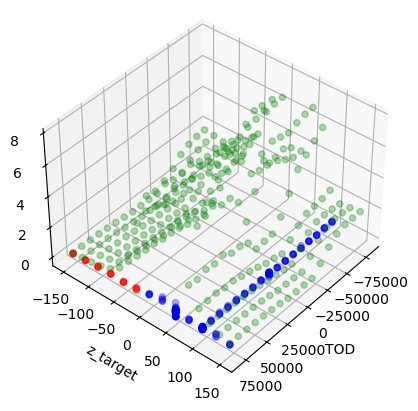

In [35]:
#Visualize the dimensional data
plt.clf()
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( expt_test_set_df['TOD_fs3'], expt_test_set_df['z_target_um'], expt_test_set_df['n_protons'], c='r',alpha=0.3)
ax.scatter( expt_training_set_df['TOD_fs3'], expt_training_set_df['z_target_um'], expt_training_set_df['n_protons'], c='b',alpha=0.3)
ax.scatter( sim_training_set_df['TOD_fs3'], sim_training_set_df['z_target_um'], sim_training_set_df['n_protons'], c='g',alpha=0.3)
ax.view_init(elev=40., azim=40, roll=0)
plt.xlabel('TOD')
plt.ylabel('z_target')

<Figure size 640x480 with 0 Axes>

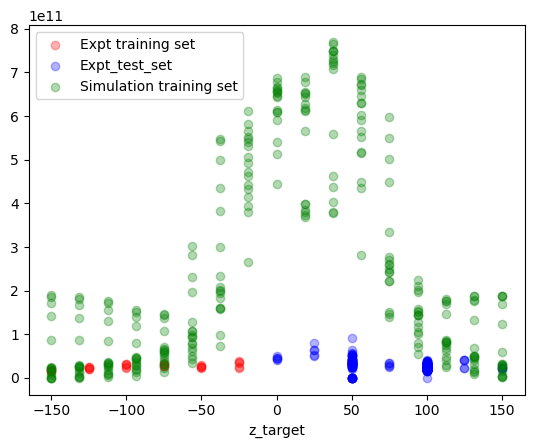

In [43]:
#Visualize the dimensional data
plt.clf()
ax = plt.figure().add_subplot()

ax.scatter(  expt_test_set_df['z_target_um'], expt_test_set_df['n_protons'], c='r',alpha=0.3,label='Expt training set')
ax.scatter( expt_training_set_df['z_target_um'], expt_training_set_df['n_protons'], c='b',alpha=0.3,label='Expt_test_set')
ax.scatter( sim_training_set_df['z_target_um'], sim_training_set_df['n_protons'], c='g',alpha=0.3,label='Simulation training set')
#ax.view_init(elev=40., azim=40, roll=0)
#plt.xlabel('TOD')
plt.xlabel('z_target')
plt.legend()

<h2> Normalize with Affine Input Transformer

In [9]:

# Define the input and output normalizations, based on the training set from experiments
X = torch.tensor(expt_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values, dtype=torch.float)
input_transform = AffineInputTransform(3, coefficient=X.std(axis=0), offset=X.mean(axis=0))
y = torch.tensor(expt_training_set_df['n_protons'].values, dtype=torch.float).reshape(-1,1)
output_transform = AffineInputTransform( 1, coefficient=y.std(axis=0), offset=y.mean(axis=0))
if (min(X.mean(axis=0)) == 0):
    print("Mean value used for normalization is 0. This will lead to NaNs ",X.mean(axis=0))
if (min(X.std(axis=0)) == 0):
    print("RMS value used for normalization is 0. This will lead to NaNs ", X.std(axis=0))




In [10]:
# Apply normalization to the sim training set
norm_sim_training_set_df = sim_training_set_df.copy()
norm_sim_training_set_df[['z_target_um', 'TOD_fs3','GVD']] = input_transform( torch.tensor( sim_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values ) )
norm_sim_training_set_df[['n_protons']] = output_transform( torch.tensor( sim_training_set_df[['n_protons']].values.reshape(-1,1) ) )

In [11]:

# Apply normalization to the training and test sets from experiments
norm_expt_training_set_df = expt_training_set_df.copy()
norm_expt_training_set_df[['z_target_um', 'TOD_fs3','GVD']] = input_transform( torch.tensor( expt_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values ) )
norm_expt_training_set_df[['n_protons']] = output_transform( torch.tensor( expt_training_set_df[['n_protons']].values.reshape(-1,1) ) )

norm_expt_test_set_df = expt_test_set_df.copy()
norm_expt_test_set_df[['z_target_um', 'TOD_fs3','GVD']] = input_transform( torch.tensor( expt_test_set_df[['z_target_um', 'TOD_fs3','GVD']].values ) )
norm_expt_test_set_df[['n_protons']] = output_transform( torch.tensor( expt_test_set_df[['n_protons']].values.reshape(-1,1) ) )

norm_expt_inputs_training = torch.tensor( norm_expt_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values, dtype=torch.float)
norm_expt_outputs_training = torch.tensor( norm_expt_training_set_df['n_protons'].values.reshape(-1,1), dtype=torch.float)

norm_expt_inputs_test = torch.tensor( norm_expt_test_set_df[['z_target_um', 'TOD_fs3','GVD']].values, dtype=torch.float)
norm_expt_outputs_test = torch.tensor( norm_expt_test_set_df['n_protons'].values.reshape(-1,1), dtype=torch.float)

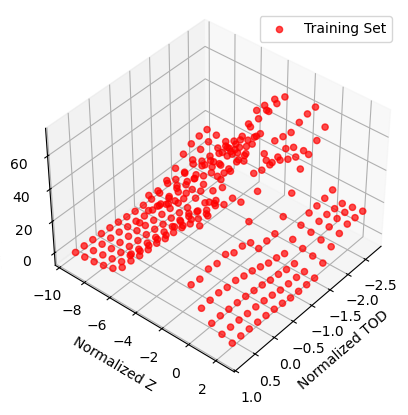

In [12]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter( norm_sim_training_set_df['TOD_fs3'], norm_sim_training_set_df['z_target_um'],
           norm_sim_training_set_df['n_protons'], c='r', alpha=0.7, label='Training Set')

ax.view_init(elev=40., azim=40, roll=0)
# Set labels and title
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized Z')
ax.set_zlabel('Normalized Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

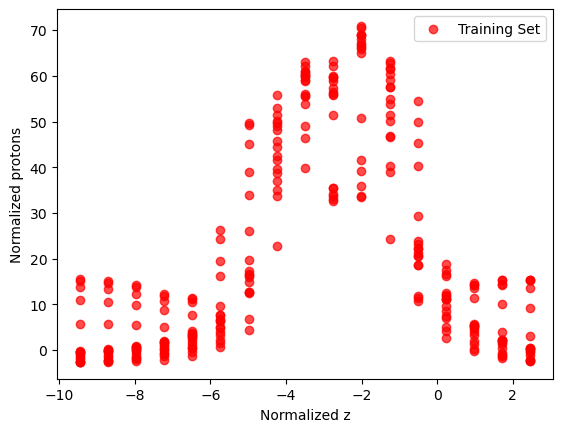

In [13]:
# Create a 2D plot
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(norm_sim_training_set_df['z_target_um'],
           norm_sim_training_set_df['n_protons'], c='r', alpha=0.7, label='Training Set')

# Set labels and title
ax.set_xlabel('Normalized z')
ax.set_ylabel('Normalized protons')

# Add legend
ax.legend()
# Show plot
plt.show()

In [14]:
norm_sim_inputs_training = torch.tensor( norm_sim_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values, dtype=torch.float)
norm_sim_outputs_training = torch.tensor( norm_sim_training_set_df['n_protons'].values.reshape(-1,1), dtype=torch.float)

<h2> Train combined NN

Epoch [10000/100000], Loss:1.467994
Epoch [20000/100000], Loss:1.066838
Epoch [30000/100000], Loss:0.999574
Epoch [40000/100000], Loss:0.969499
Epoch [50000/100000], Loss:0.959575
Epoch [60000/100000], Loss:0.959564
Epoch [70000/100000], Loss:0.959553
Epoch [80000/100000], Loss:0.959541
Epoch [90000/100000], Loss:0.959530
Epoch [100000/100000], Loss:0.959520


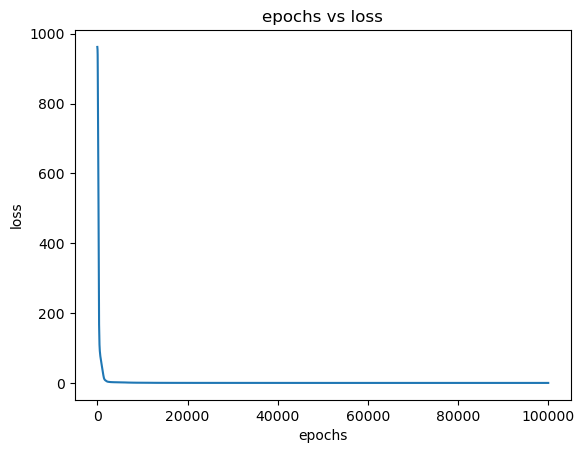

In [25]:
calibrated_nn = CombinedNN(learning_rate=0.0005)
calibrated_nn.train_model(norm_sim_inputs_training, norm_sim_outputs_training,
                    norm_expt_inputs_training, norm_expt_outputs_training, num_epochs=100000)

calibrated_nn.plot_loss()

In [26]:
sim_train_predictions = calibrated_nn.predict_sim(norm_sim_inputs_training)

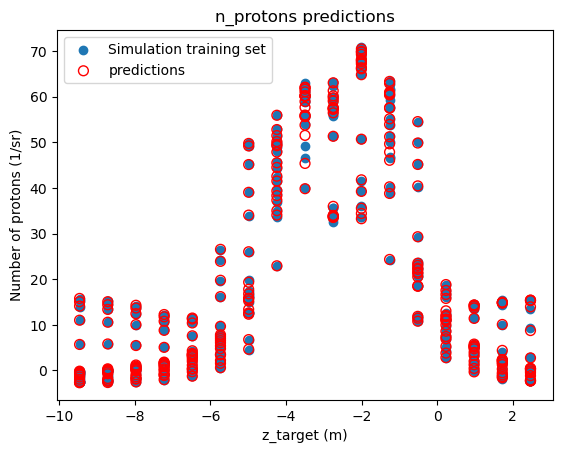

In [27]:
fig, ax = plt.subplots()

ax.scatter(norm_sim_training_set_df['z_target_um'], norm_sim_training_set_df['n_protons'], label='Simulation training set')
ax.scatter(norm_sim_training_set_df['z_target_um'], sim_train_predictions, label='predictions', s=50, facecolors='none', edgecolors='r')

plt.title("n_protons predictions")
plt.xlabel('z_target (m)')
plt.ylabel('Number of protons (1/sr)')
plt.legend()

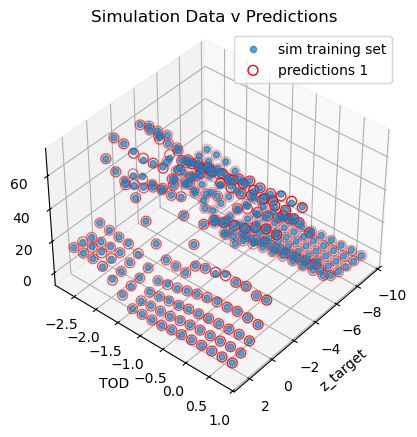

In [28]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for training set
ax.scatter(norm_sim_training_set_df['z_target_um'], norm_sim_training_set_df['TOD_fs3'], norm_sim_training_set_df['n_protons'], label='sim training set', alpha=0.7)
ax.scatter( norm_sim_training_set_df['z_target_um'], norm_sim_training_set_df['TOD_fs3'], sim_train_predictions.flatten(), label='predictions 1', s=50, facecolors='none', edgecolors='r')

ax.view_init(elev=40., azim=40)
# Set labels and title
ax.set_title('Simulation Data v Predictions')
ax.set_xlabel('z_target')
ax.set_ylabel('TOD')
ax.set_zlabel('n Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

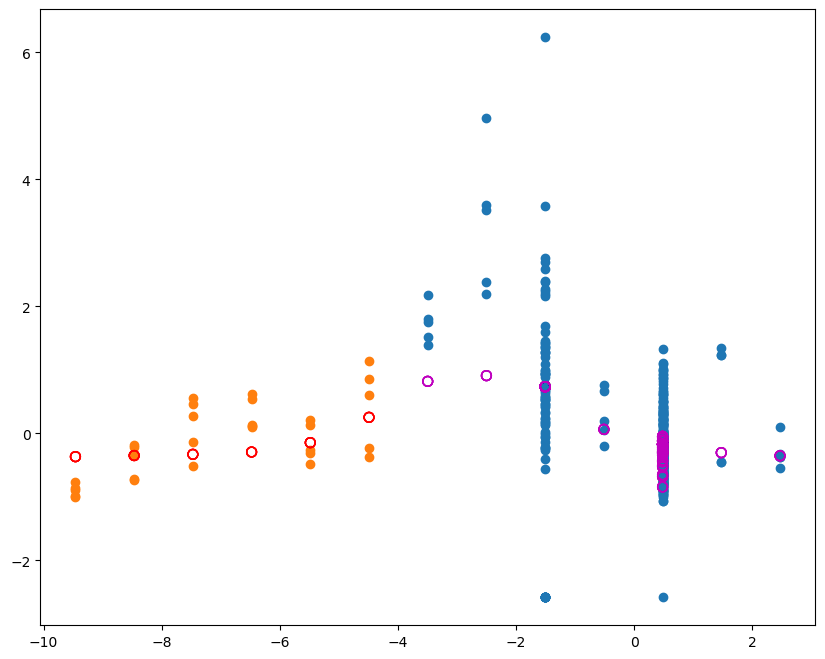

In [29]:

test_on_expt = calibrated_nn.predict_exp(norm_expt_inputs_test)
test_on_trainexpt = calibrated_nn.predict_exp(norm_expt_inputs_training)
fig, ax = plt.subplots(figsize=(10,8))

# with torch.no_grad():
#     ax.scatter(norm_sim_training_set_df['z_target_um'],
#                calibrated_nn.sim_to_exp_calibration(torch.tensor(norm_sim_training_set_df['n_protons'].values.reshape(-1,1), dtype=torch.float)), label='Calibrated simulation training set')
ax.scatter(norm_expt_training_set_df['z_target_um'], norm_expt_training_set_df['n_protons'], label='Expt training set')
ax.scatter(norm_expt_test_set_df['z_target_um'], norm_expt_test_set_df['n_protons'], label='Expt test set')

ax.scatter(norm_expt_training_set_df['z_target_um'], test_on_trainexpt, label=' expt train predictions', s=50, facecolors='none', edgecolors='m')
ax.scatter(norm_expt_test_set_df['z_target_um'], test_on_expt,label=' expt test predictions', s=50, facecolors='none', edgecolors='r')

#ax.scatter(norm_sim_training_set_df['z_target_um'], sim_train_predictions, label='predictions', s=50, facecolors='none', edgecolors='r')

<h2> Saving the Lume Model - TO do for combined NN

In [30]:
from lume_model.models import TorchModel
from lume_model.variables import ScalarVariable #, ScalarVariable
model = TorchModel

In [31]:
input_variables = [
    ScalarVariable(name="z_target_um", default_value=0.1, value_range=[-150,150]),
    ScalarVariable(name="TOD_fs3", default_value=0.1, value_range=[-8e4,8e4]),
    ScalarVariable(name="GVD", default_value=13.5, value_range=[13.2,13.9])
]

output_variables = [
    ScalarVariable(name="n_protons", default_value=0, value_range=[0,8e10])
]


calibration_transform = AffineInputTransform( 1, coefficient=calibrated_nn.sim_to_exp_calibration.weight.clone(), offset=calibrated_nn.sim_to_exp_calibration.weight.clone() )


In [32]:
model = TorchModel(
    model=calibrated_nn,
    input_variables=input_variables,
    output_variables=output_variables
)

model.dump( file='base_simulation_model_with_transformers_new.yml', save_jit=True)

<h2> Load Model

<Figure size 640x480 with 0 Axes>

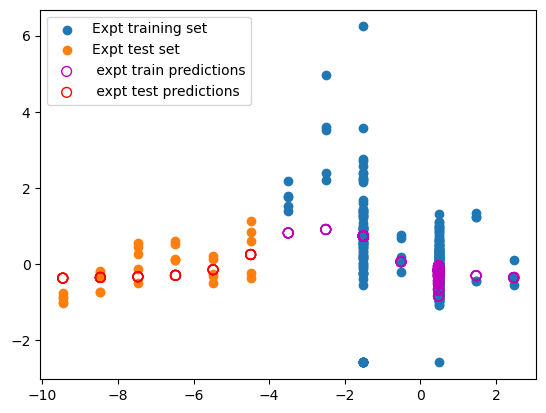

In [44]:
loaded_model = torch.jit.load('base_simulation_model_with_transformers_new_model.jit')
loaded_model = loaded_model.to(torch.float)
plt.clf()
ax = plt.figure().add_subplot()
#ax.scatter(norm_sim_training_set_df['z_target_um'], norm_sim_training_set_df['n_protons'], label='Simulation training set')
ax.scatter(norm_expt_training_set_df['z_target_um'], norm_expt_training_set_df['n_protons'], label='Expt training set')
ax.scatter(norm_expt_test_set_df['z_target_um'], norm_expt_test_set_df['n_protons'], label='Expt test set')

with torch.no_grad():
    output = loaded_model.calibrate(loaded_model(norm_expt_inputs_training))
    numpy_array = output.numpy()
ax.scatter(norm_expt_training_set_df['z_target_um'], numpy_array, label=' expt train predictions', s=50, facecolors='none', edgecolors='m')

with torch.no_grad():
    output = loaded_model.calibrate(loaded_model(norm_expt_inputs_test))
    numpy_array = output.numpy()
ax.scatter(norm_expt_test_set_df['z_target_um'], numpy_array,label=' expt test predictions', s=50, facecolors='none', edgecolors='r')
plt.legend()
plt.show()# loaded_model.eval()